# Import

#### Install the necessary packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import imgaug
import skimage
import imgaug.augmenters as aug
import mrcnn.model as modellib
from mrcnn import utils
from tensorflow.keras.callbacks import TensorBoard

import furniture as ft

Using TensorFlow backend.


# Initialize
##### Set up the folder path:

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# For TensorBoard
NAME = 'Mask-RCNN-furniture-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

DATA_DIR = os.path.join(ROOT_DIR, "dataset")

real_test_dir = './dataset/real_test/'

... done downloading pretrained model!


##### Configuration:

In [3]:
class FinalConfig(ft.FurnitureConfig):
    
    IMAGE_MAX_DIM = 256
    IMAGE_MIN_DIM = 256
    
    POST_NMS_ROIS_TRAINING = 10
    
    DETECTION_MIN_CONFIDENCE = 0.8
    
    BACKBONE = 'resnet50'
    
    
config = FinalConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

##### Configuration for baseline

# Load Data
##### load the training data and testing data

In [4]:
dataset_train = ft.FurnitureDataset()
dataset_train.load_data('./dataset/train/coco.json', './dataset/train/')
dataset_train.prepare()

dataset_val = ft.FurnitureDataset()
dataset_val.load_data('./dataset/val/coco.json', './dataset/val/')
dataset_val.prepare()

# Data Augmentation

In [5]:
augmentation = imgaug.augmenters.Sometimes(1 / 2, aug.OneOf(
    [
        imgaug.augmenters.Fliplr(1),
        imgaug.augmenters.Flipud(1),
        imgaug.augmenters.Affine(rotate=(-45, 45)),
        imgaug.augmenters.Affine(rotate=(-90, 90)),
        imgaug.augmenters.Affine(scale=(0.5, 1.5))
    ]
))

# Display the image
##### Randomly pick up some image and display it

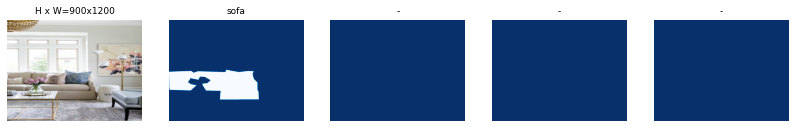

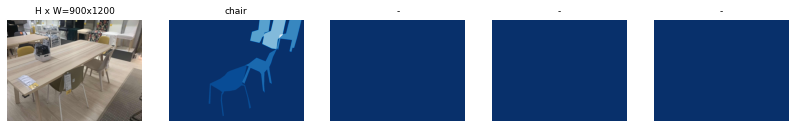

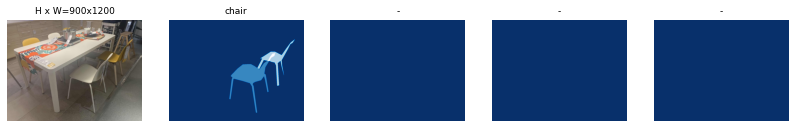

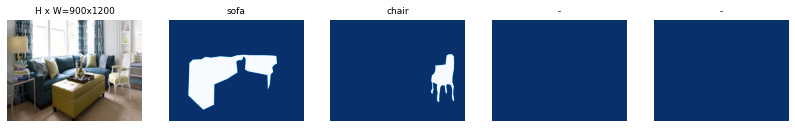

In [14]:
display = dataset_train
display.display_mask()

# Create model
##### load the model by using Mask-rcnn backbone

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

##### load the COCO weight

In [8]:
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

# Train the model

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=100,
            layers="all",
            custom_callbacks=[tensorboard],
            augmentation=augmentation)

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

# Inference
##### setup the configuration for testing

In [28]:
class InferenceConfig(ft.FurnitureConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    DETECTION_MIN_CONFIDENCE = 0.7
    POST_NMS_ROIS_TRAINING = 10

inference_config = InferenceConfig()

##### load the model for inference

In [29]:
# Recreate the model in inference mode
inference_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [30]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = inference_model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
inference_model.load_weights(model_path, by_name=True)

Loading weights from  D:\IRS-RTAVS-2020-04-11-ISY5004-GRP-2Z1Y_MaskRCNN\logs\furniture20200509T1315\mask_rcnn_furniture_0100.h5
Re-starting from epoch 100


##### perform the inference on testing image

Processing 1 images
image                    shape: (544, 900, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  900.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


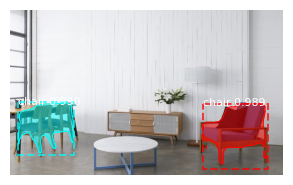

Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  275.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


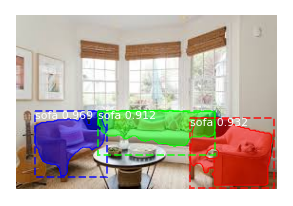

Processing 1 images
image                    shape: (134, 376, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  376.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


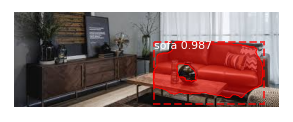

Processing 1 images
image                    shape: (155, 324, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  324.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


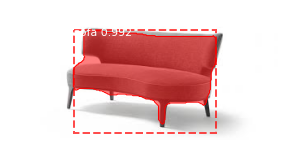

Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


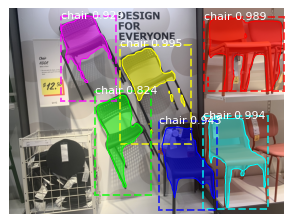

Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


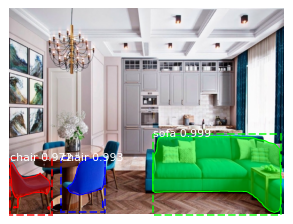

Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


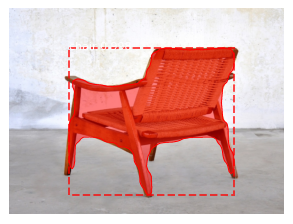

Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


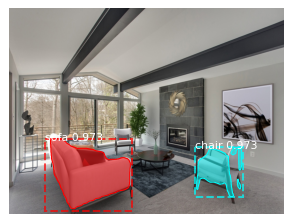

In [31]:
ft.inference(inference_model, real_test_dir, dataset_val)

In [32]:
accuracy = dataset_val.evaluate_mAP(inference_model, inference_config, 100)
print("The overall accuracy of the model is : {}".format(accuracy))

The overall accuracy of the model is : 0.7555211644503805
